<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [ ]:
!git clone https://github.com/AmbiTyga/pytorch-image-models.git
%cd pytorch-image-models
!git checkout hidden_states
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

import os
os.kill(os.getpid(), 9)
# Restart Runtime

In [1]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
!7z x /content/Dataset.7z

--2021-03-12 09:53:47--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20035294 (19M) [application/octet-stream]
Saving to: ‘Dataset.7z’

Dataset.7z          100%[===================>]  19.11M  43.8MB/s    in 0.4s    

2021-03-12 09:53:49 (43.8 MB/s) - ‘Dataset.7z’ saved [20035294/20035294]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 20035294 bytes (20 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Dat

In [3]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms

## Cleaning and getting a final data

In [37]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [36]:
data = pd.read_excel("/content/Dataset/all_meta_data.xlsx")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [37]:
del le

In [38]:
data = [x for _,x in data.groupby('species') if len(x)>15]

data = pd.concat(data,ignore_index=True)

label_encoders = dict()
labels = ["phylum","class","species","form","sample"]
for x in labels:
  le = LabelEncoder()
  data[f'{x}_label'] = le.fit_transform(data[x])
  label_encoders[x] = le

In [39]:
train, val = train_test_split(
    data, test_size=0.25, random_state=2021,stratify = data['species'])

In [40]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Dataset Function

In [10]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = pd.read_csv(csv_file)[['species_label','img_path']]
    self.labels = csv['species_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return img, torch.LongTensor([label])

In [11]:

train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        # transforms.
        # transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [45]:
15*5

75

In [46]:
class_counts = train['species_label'].value_counts().to_dict()
weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = SpeciesDataset('/content/train.csv',transform=train_transformer)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=39,
                                           sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=448))

val = pd.read_csv('/content/val.csv')
class_counts = val['species_label'].value_counts().to_dict()
weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=17,
                                         sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=75))

# VIT Base Imagenet 21k

In [ ]:
vi = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 512)
vi

In [47]:
class ViT(nn.Module):
  def __init__(self,num_classes_classifier=20):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 0)
    self.fc1 = nn.Linear(768,512)
    self.drop = nn.Dropout(0.4)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = self.fc1(repr)
    repr = self.drop(repr)
    output = self.classifier(repr)

    return output  

In [48]:
model = ViT()

Removing representation layer for fine-tuning.


In [ ]:
model.load_state_dict(torch.load('vit-base.bin'))

<All keys matched successfully>

In [49]:
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = np.inf

model.to(device)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit-base.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 2.856, Train Acc: 25.26%, Val. Loss: 2.747, Val. Acc: 23.36% 
	inf --> 2.747  Updating
Epoch: 02, Train Loss: 2.569, Train Acc: 45.83%, Val. Loss: 2.514, Val. Acc: 32.77% 
	2.747 --> 2.514  Updating
Epoch: 03, Train Loss: 2.239, Train Acc: 61.03%, Val. Loss: 2.244, Val. Acc: 52.10% 
	2.514 --> 2.244  Updating
Epoch: 04, Train Loss: 1.878, Train Acc: 72.38%, Val. Loss: 1.916, Val. Acc: 68.24% 
	2.244 --> 1.916  Updating
Epoch: 05, Train Loss: 1.535, Train Acc: 79.64%, Val. Loss: 1.589, Val. Acc: 70.76% 
	1.916 --> 1.589  Updating
Epoch: 06, Train Loss: 1.252, Train Acc: 86.70%, Val. Loss: 1.506, Val. Acc: 62.02% 
	1.589 --> 1.506  Updating
Epoch: 07, Train Loss: 0.985, Train Acc: 86.70%, Val. Loss: 1.384, Val. Acc: 62.02% 
	1.506 --> 1.384  Updating
Epoch: 08, Train Loss: 0.747, Train Acc: 94.02%, Val. Loss: 1.002, Val. Acc: 79.50% 
	1.384 --> 1.002  Updating
Epoch: 09, Train Loss: 0.519, Train Acc: 96.58%, Val. Loss: 1.016, Val. Acc: 74.29% 
	 Patience -> 9
Epoch

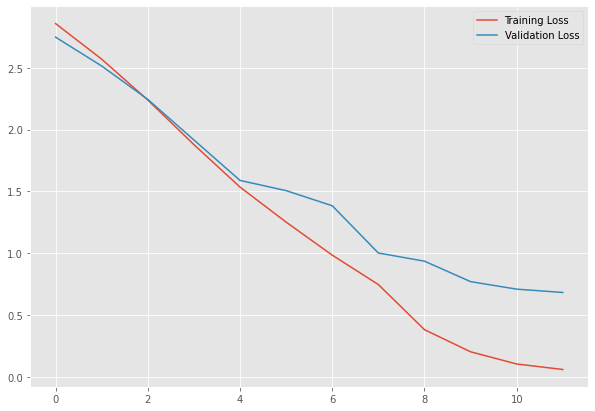

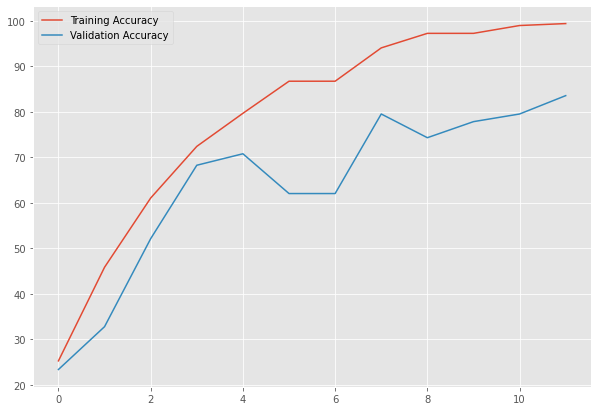

In [50]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [53]:
val.shape

(104, 14)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=104)

model.load_state_dict(torch.load('vit-base.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=label_encoders['species'].classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       0.80      1.00      0.89         4
     Ascaris lumbricoides       0.64      0.78      0.70         9
      Cryptosporidium sp.       0.80      1.00      0.89         4
  Cyclospora cayetanensis       0.73      0.89      0.80         9
  Dibothriocephalus latus       1.00      0.60      0.75         5
   Entamoeba histolytica]       1.00      0.43      0.60         7
  Enterobius vermicularis       0.38      0.60      0.46         5
       Giardia duodenalis       0.70      1.00      0.82         7
    Plasmodium falciparum       0.69      1.00      0.82         9
      Plasmodium malariae       0.73      0.89      0.80         9
         Plasmodium ovale       0.80      0.44      0.57         9
         Plasmodium vivax       1.00      0.78      0.88         9
          Sarcocystis sp.       1.00      0.75      0.86         4
Strongyloides stercoralis       0.75      0.60      0.67     

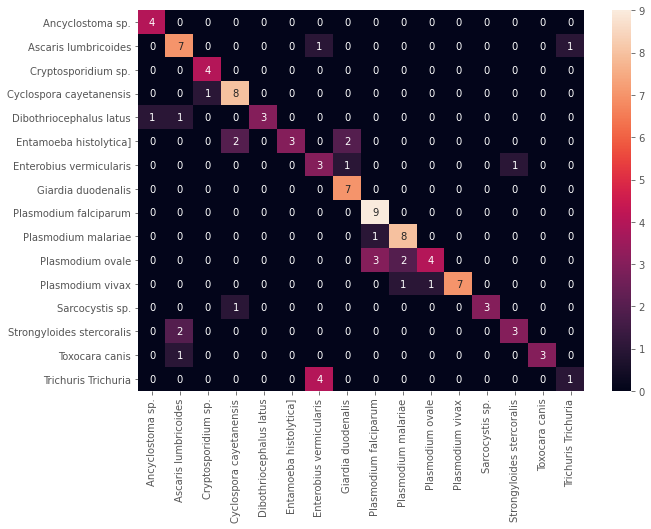

In [57]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = label_encoders['species'].classes_,
                  columns = label_encoders['species'].classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# VIT Resnet50 Imagenet 21k

In [ ]:
class ViResNet50(nn.Module):
  def __init__(self,num_classes_classifier=16):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_resnet50_224_in21k(pretrained=True,num_classes = 512)
    self.drop = nn.Dropout(0.4)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = self.drop(repr)
    output = self.classifier(repr)

    return output  

In [ ]:
model = ViResNet50()

Removing representation layer for fine-tuning.


In [ ]:
model.load_state_dict(torch.load('vit-resnet.bin'))

<All keys matched successfully>

In [ ]:
torch.seed()

14185017976319700136

In [ ]:
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = np.inf

model.cuda()

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)
    loss.backward()

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit-resnet.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 0.056, Train Acc: 100.00%, Val. Loss: 0.882, Val. Acc: 77.16% 
	inf --> 0.882  Updating
Epoch: 02, Train Loss: 0.030, Train Acc: 100.00%, Val. Loss: 0.729, Val. Acc: 77.84% 
	0.882 --> 0.729  Updating
Epoch: 03, Train Loss: 0.064, Train Acc: 98.30%, Val. Loss: 0.969, Val. Acc: 72.84% 
	 Patience -> 9
Epoch: 04, Train Loss: 0.055, Train Acc: 98.48%, Val. Loss: 1.109, Val. Acc: 77.35% 
	 Patience -> 8
Epoch: 05, Train Loss: 0.076, Train Acc: 97.73%, Val. Loss: 1.067, Val. Acc: 73.33% 
	 Patience -> 7
Epoch: 06, Train Loss: 0.075, Train Acc: 98.30%, Val. Loss: 0.908, Val. Acc: 73.14% 
	 Patience -> 6
Epoch: 07, Train Loss: 0.019, Train Acc: 99.81%, Val. Loss: 1.118, Val. Acc: 74.51% 
	 Patience -> 5
Epoch: 08, Train Loss: 0.031, Train Acc: 99.43%, Val. Loss: 1.098, Val. Acc: 77.55% 
	 Patience -> 4
Epoch: 09, Train Loss: 0.014, Train Acc: 100.00%, Val. Loss: 1.031, Val. Acc: 80.00% 
	 Patience -> 3
Epoch: 10, Train Loss: 0.028, Train Acc: 99.62%, Val. Loss: 1.501, V

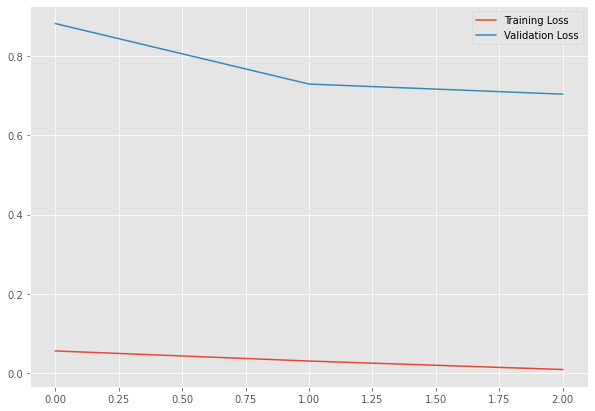

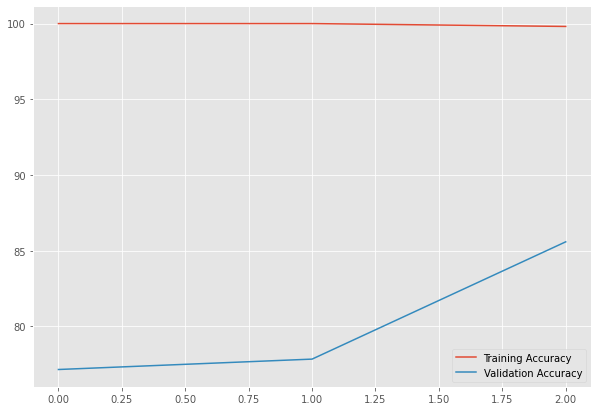

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)
model.load_state_dict(torch.load('vit-resnet.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=val_dataset.LE.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       1.00      0.50      0.67         2
     Ascaris lumbricoides       1.00      1.00      1.00         4
      Cryptosporidium sp.       1.00      1.00      1.00         2
  Cyclospora cayetanensis       1.00      1.00      1.00         4
  Dibothriocephalus latus       1.00      1.00      1.00         3
   Entamoeba histolytica]       0.80      1.00      0.89         4
  Enterobius vermicularis       0.50      0.50      0.50         2
       Giardia duodenalis       1.00      0.75      0.86         4
    Plasmodium falciparum       1.00      0.80      0.89         5
      Plasmodium malariae       0.60      0.75      0.67         4
         Plasmodium ovale       0.50      1.00      0.67         3
         Plasmodium vivax       1.00      0.60      0.75         5
          Sarcocystis sp.       1.00      1.00      1.00         2
Strongyloides stercoralis       0.50      0.67      0.57     

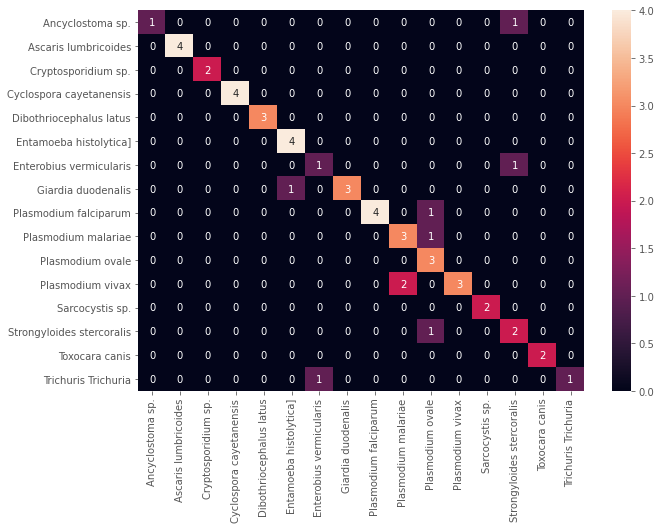

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = val_dataset.LE.classes_,
                  columns = val_dataset.LE.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()